In [1]:
###Made in python 3.9.4, using pandas, numpy, scikit-learn, matplotlib, missingno and seaborn
#unzip/open file and import some important libraries
import tarfile
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if os.path.isfile("latestdata.csv"):
    covid_df = pd.read_csv("latestdata.csv", low_memory=False)
elif os.path.isfile("latestdata.tar.gz"):
    file = tarfile.open("latestdata.tar.gz")
    file.extractall()
    file.close()
    covid_df = pd.read_csv("latestdata.csv", low_memory=False)
else:
    print("Cannot find file")
    exit()

In [2]:
print(covid_df.shape)
print(covid_df["outcome"].count())

(2676311, 33)
307382


In [3]:
#drop all rows without a value for outcome
labelled_df = covid_df.copy()
labelled_df.dropna(subset=["outcome"], inplace=True)
print(labelled_df.shape)

(307382, 33)


In [4]:
#convert outcome to 0- deceased or 1- recovered/discharged/stable
labelled_df["outcome"].replace(["Recovered", "recovered", "discharge", "stable", "stable condition", "discharged", "Stable",
                   "Discharged from hospital", "Discharged"], 1, inplace=True)
labelled_df["outcome"].replace(["Deceased", "died", "death", "Dead", "Death", "Died", "dead"], 0, inplace=True)

#if we cannot be sure of outcome from entry convert to np.nan then drop
labelled_df["outcome"].replace(to_replace=r"[^0-1]", value=np.nan, regex=True, inplace=True)
labelled_df.dropna(subset=["outcome"], inplace=True)

print(labelled_df["outcome"].value_counts())

1.0    97933
0.0     5999
Name: outcome, dtype: int64


In [5]:
#drop data elements that are deemed useless 
labelled_df.drop(["ID", "admin_id", "data_moderator_initials", "source", "sequence_available",
                 "additional_information", "notes_for_discussion"], axis=1, inplace=True)
print(labelled_df.columns)

Index(['age', 'sex', 'city', 'province', 'country', 'latitude', 'longitude',
       'geo_resolution', 'date_onset_symptoms', 'date_admission_hospital',
       'date_confirmation', 'symptoms', 'lives_in_Wuhan',
       'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'chronic_disease_binary', 'chronic_disease',
       'outcome', 'date_death_or_discharge', 'location', 'admin3', 'admin2',
       'admin1', 'country_new', 'travel_history_binary'],
      dtype='object')


In [6]:
#create dataframe of numeric features and binary categoric variables that can be converted to numeric features easily
numeric_df = labelled_df[["age", "sex", "lives_in_Wuhan", "travel_history_binary", "reported_market_exposure", 
                          "chronic_disease_binary", "date_death_or_discharge", "date_onset_symptoms", 
                          "date_admission_hospital", "date_confirmation", "travel_history_dates", "outcome"]].copy()

In [7]:
#convert binary categorical features to numeric features with 0's and 1's, e.g. sex and chronic_disease_binary
numeric_df = numeric_df.replace("male", 1)
numeric_df = numeric_df.replace("female", 0)
numeric_df = numeric_df.replace("no", 0)
numeric_df = numeric_df.replace("yes", 1)
numeric_df = numeric_df.replace(False, 0)
numeric_df = numeric_df.replace(True, 1)
numeric_df = numeric_df.replace("na", np.nan)
numeric_df = numeric_df.replace(["contact with a positive case", "yes, retailer in the seafood wholesale market"], 1)

#function to convert age to integers and take average when a range is given
def f_age(row):
    row_age = row["age"]
    if isinstance(row_age, float):
        return row_age
    elif "weeks" in row_age:
        return 0 
    elif row_age[-1] == "-" or row_age[-1] == "+":
        row_age = row_age[:-1]
    elif "month" in row_age:
            mon_age = int(row_age[:2])
            return int((mon_age / 12))
    elif len(row_age) > 2 and "." not in row_age:
        if "-" in row_age:
            age_list = row_age.split("-")
            age1 = int(age_list[0])
            age2 = int(age_list[1])
            avg_age = (age1 + age2) / 2
            return int(avg_age)
        else:
            return int(row_age)
    else: 
        if "." in row_age:
            fl = float(row_age)
            return int(fl)
        else:
            return int(row_age)
        
#clean up age
fun = lambda row: f_age(row)
col = numeric_df.apply(fun, axis=1)
numeric_df = numeric_df.assign(age=col.values)

In [8]:
print(numeric_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103932 entries, 1 to 673607
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       5762 non-null    float64
 1   sex                       6906 non-null    float64
 2   lives_in_Wuhan            172 non-null     float64
 3   travel_history_binary     103616 non-null  float64
 4   reported_market_exposure  12 non-null      float64
 5   chronic_disease_binary    103932 non-null  int64  
 6   date_death_or_discharge   1190 non-null    object 
 7   date_onset_symptoms       3529 non-null    object 
 8   date_admission_hospital   295 non-null     object 
 9   date_confirmation         103861 non-null  object 
 10  travel_history_dates      196 non-null     object 
 11  outcome                   103932 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 10.3+ MB
None


Number of missing values: 
reported_market_exposure    103920
lives_in_Wuhan              103760
travel_history_dates        103736
date_admission_hospital     103637
date_death_or_discharge     102742
date_onset_symptoms         100403
age                          98170
sex                          97026
travel_history_binary          316
date_confirmation               71
chronic_disease_binary           0
outcome                          0
dtype: int64
missing value correlation heatmap
visualisation of missing values for first 500 rows of dataset: 


<AxesSubplot:>

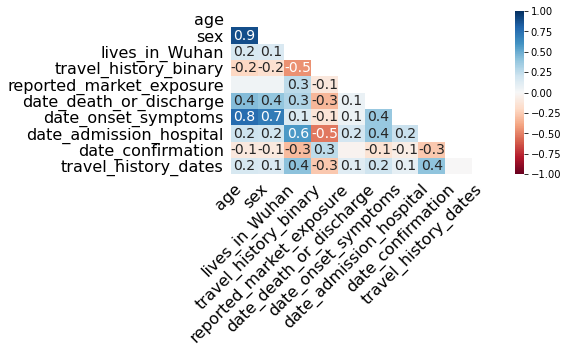

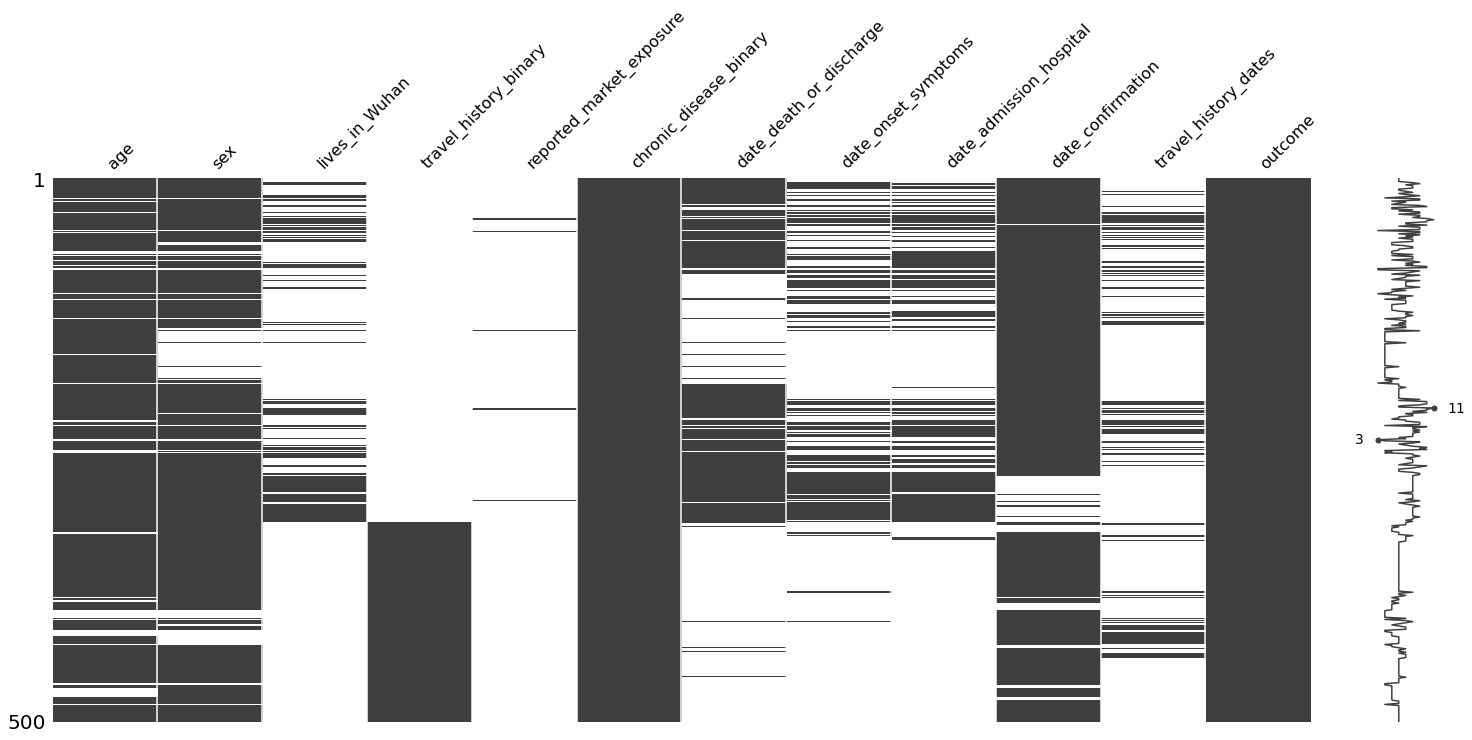

In [9]:
#investigate/visualize missing values for selected numerical features
import missingno as msno
missing_df = numeric_df.copy()
#reset indexes to help see patterns
missing_df.index = np.arange(len(missing_df))

#print number missing values in samples
print("Number of missing values: ")
print(missing_df.isnull().sum().sort_values(ascending=False))

#visualize correlation of missing values
print("missing value correlation heatmap")
msno.heatmap(missing_df, figsize=(6,3))

#visualise sample missing values
print("visualisation of missing values for first 500 rows of dataset: ")
msno.matrix(numeric_df.iloc[0:500][:])

In [10]:
#imputing missing values except age and sex
from sklearn.impute import SimpleImputer

#show some missing values
print("example rows before imputation: ")
print(numeric_df.iloc[18:20, :4], "   ...")

#impute other missing values using mode strategy
my_other_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
numeric_df["date_confirmation"] = my_other_imputer.fit_transform(numeric_df[["date_confirmation"]]).ravel()
numeric_df["date_admission_hospital"] = my_other_imputer.fit_transform(numeric_df[["date_admission_hospital"]]).ravel()
numeric_df["date_onset_symptoms"] = my_other_imputer.fit_transform(numeric_df[["date_onset_symptoms"]]).ravel()
numeric_df["date_death_or_discharge"] = my_other_imputer.fit_transform(numeric_df[["date_death_or_discharge"]]).ravel()
numeric_df["travel_history_dates"] = my_other_imputer.fit_transform(numeric_df[["travel_history_dates"]]).ravel()
#impute other values with 0's
numeric_df["travel_history_binary"].fillna(0, inplace = True)
numeric_df["chronic_disease_binary"].fillna(0, inplace = True)
numeric_df["lives_in_Wuhan"].fillna(0, inplace = True)
numeric_df["reported_market_exposure"].fillna(0, inplace = True)

print("example rows after imputation (except age/sex): ")
print(numeric_df.iloc[18:20, :4], "   ...")

example rows before imputation: 
       age  sex  lives_in_Wuhan  travel_history_binary
1779   NaN  NaN             NaN                    NaN
1890  58.0  0.0             0.0                    NaN    ...
example rows after imputation (except age/sex): 
       age  sex  lives_in_Wuhan  travel_history_binary
1779   NaN  NaN             0.0                    0.0
1890  58.0  0.0             0.0                    0.0    ...


In [11]:
#create random forest model to predict missing values for sex
from sklearn.ensemble import RandomForestRegressor

#use numeric features and location information to help predict
df_comp = numeric_df.drop(["date_death_or_discharge", "date_onset_symptoms", "date_admission_hospital", 
                           "date_confirmation", "travel_history_dates", "outcome", "age"], axis=1).copy()
df_comp[["country", "city", "province"]] = labelled_df[["country", "city", "province"]]
df_comp = pd.get_dummies(df_comp)

#create dataframe with and without sex
df_sex = df_comp[pd.isnull(df_comp['sex']) == False].copy()
df_sex_dropped = df_sex.drop(["sex"], axis=1)

df_sex_null = df_comp[pd.isnull(df_comp['sex']) == True].copy()
df_sex_null_dropped = df_sex_null.drop(["sex"], axis=1)

#random forest regressor
rf_predictor = RandomForestRegressor()
rf_predictor.fit(df_sex_dropped, df_sex["sex"])
sex_imputes = rf_predictor.predict(X = df_sex_null_dropped)

#put imputed values into main df
df_sex_null_dropped["sex"] = sex_imputes
df_imputed_sex = df_sex.append(df_sex_null_dropped)
numeric_df["sex"] = df_imputed_sex["sex"]

In [12]:
#create random forest model to predict missing value for age
#use numeric features and location information to help predict
df_comp = numeric_df.drop(["date_death_or_discharge", "date_onset_symptoms", "date_admission_hospital", 
                           "date_confirmation", "travel_history_dates", "outcome"], axis=1).copy()
df_comp[["country", "city", "province"]] = labelled_df[["country", "city", "province"]]
df_comp = pd.get_dummies(df_comp)

#create df with and without age
df_age = df_comp[pd.isnull(df_comp['age']) == False].copy()
df_age_dropped = df_age.drop(["age"], axis=1)

df_age_null = df_comp[pd.isnull(df_comp['age']) == True].copy()
df_age_null_dropped = df_age_null.drop(["age"], axis=1)

#random forest regressor
rf_predictor = RandomForestRegressor()
rf_predictor.fit(df_age_dropped, df_age["age"])
age_imputes = rf_predictor.predict(X = df_age_null_dropped)

#add imputed values back into original df
df_age_null_dropped["age"] = age_imputes
df_imputed_age = df_age.append(df_age_null_dropped)
numeric_df["age"] = df_imputed_age["age"]

print("example rows after full imputation: ")
print(numeric_df.iloc[18:20, :4], "   ...")

example rows after full imputation: 
            age       sex  lives_in_Wuhan  travel_history_binary
1779  56.473705  0.930667             0.0                    0.0
1890  58.000000  0.000000             0.0                    0.0    ...


In [13]:
print("columns sorted by number of missing values: ")
print(numeric_df.isnull().sum().sort_values(ascending=False).head(3))
print("...")

columns sorted by number of missing values: 
age               0
sex               0
lives_in_Wuhan    0
dtype: int64
...


In [14]:
print("age before feature scaling: ")
print(numeric_df["age"].head(-5))

age before feature scaling: 
1         78.0
2         61.0
113       28.0
224       56.0
335       79.0
          ... 
649975    74.0
657753    54.0
658603    24.0
658864    84.0
661086    84.0
Name: age, Length: 103927, dtype: float64


age distribution: 


array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

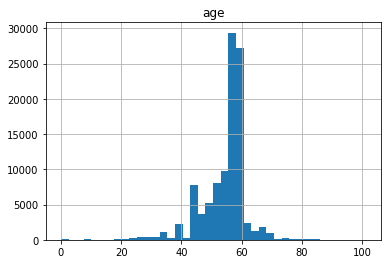

In [15]:
print("age distribution: ")
numeric_df.hist(column="age", bins=40)

In [16]:
#feature scaling 
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
numeric_df[["age"]] = my_scaler.fit_transform(numeric_df[["age"]])

print(numeric_df["age"].head(-5))

1         3.076382
2         0.828695
113      -3.534464
224       0.167610
335       3.208599
            ...   
649975    2.547515
657753   -0.096824
658603   -4.063331
658864    3.869684
661086    3.869684
Name: age, Length: 103927, dtype: float64


In [17]:
#look at correlation with output variable for numerical features where this makes sense
correlation_df = numeric_df[["age", "sex", "lives_in_Wuhan", "reported_market_exposure","chronic_disease_binary",
                             "travel_history_binary", "outcome"]]
correlation_df.corr()

,age,sex,lives_in_Wuhan,reported_market_exposure,chronic_disease_binary,travel_history_binary,outcome
age,1.000000,0.375305,-0.003862,-0.002351,0.062875,-0.087701,-0.057680
sex,0.375305,1.000000,-0.023532,-0.011959,-0.021266,-0.043760,0.022506
lives_in_Wuhan,-0.003862,-0.023532,1.000000,0.103096,0.208849,0.117920,-0.050197
reported_market_exposure,-0.002351,-0.011959,0.103096,1.000000,0.088334,-0.000224,0.000768
chronic_disease_binary,0.062875,-0.021266,0.208849,0.088334,1.000000,0.291014,-0.113648
travel_history_binary,-0.087701,-0.043760,0.117920,-0.000224,0.291014,1.000000,-0.038283
outcome,-0.057680,0.022506,-0.050197,0.000768,-0.113648,-0.038283,1.000000


In [18]:
#use number of missing values, correlation with outcome and intuition to decide which numerical features to keep
numeric_df.drop(["date_onset_symptoms", "date_admission_hospital", "date_confirmation", "lives_in_Wuhan",
                 "travel_history_dates", "reported_market_exposure", "date_death_or_discharge"], axis=1, inplace=True)
print("numeric features: ", numeric_df.columns)

numeric features:  Index(['age', 'sex', 'travel_history_binary', 'chronic_disease_binary',
       'outcome'],
      dtype='object')


In [19]:
#drop numerical features not chosen from main labelled dataframe
lab_df = labelled_df.drop(["date_onset_symptoms", "date_admission_hospital", "date_confirmation", "lives_in_Wuhan",
                  "travel_history_dates", "reported_market_exposure", "date_death_or_discharge"], axis=1).copy()

In [20]:
#replace columns in labelled dataframe with cleaned numeric columns
lab_df.drop(["sex", "age", "travel_history_binary", "chronic_disease_binary", "outcome"], axis=1, inplace=True)
lab_df = pd.concat([lab_df, numeric_df["sex"], numeric_df["age"], numeric_df["travel_history_binary"],
                        numeric_df["chronic_disease_binary"], numeric_df["outcome"]], axis=1)
print(lab_df.shape)

(103932, 19)


In [21]:
#balance dataset as we are building a predictive model, and there are many more 0's in our dataset than 1's for outcome
from sklearn.utils import resample

df_posotive = lab_df[lab_df.outcome == 1]
df_negative = lab_df[lab_df.outcome == 0]

df_posotive_balanced = resample(df_posotive, n_samples=len(df_negative), replace=False, random_state=0)

df_balanced = pd.concat([df_posotive_balanced, df_negative])
print(df_balanced["outcome"].value_counts())
print(df_balanced.count())

0.0    5999
1.0    5999
Name: outcome, dtype: int64
city                       10371
province                   11926
country                    11996
latitude                   11998
longitude                  11998
geo_resolution             11998
symptoms                     145
travel_history_location       61
chronic_disease              106
location                     301
admin3                         7
admin2                       123
admin1                      1506
country_new                11166
sex                        11998
age                        11998
travel_history_binary      11998
chronic_disease_binary     11998
outcome                    11998
dtype: int64


In [22]:
#deal with categorical variables
#I will use city, province and country for location data as they are standardized and have few missing values
df_balanced.drop(["latitude", "longitude", "geo_resolution", "admin3", "admin2", "admin1", "country_new",
                  "location"], axis=1, inplace=True)
print("final list of features: ", df_balanced.columns)

final list of features:  Index(['city', 'province', 'country', 'symptoms', 'travel_history_location',
       'chronic_disease', 'sex', 'age', 'travel_history_binary',
       'chronic_disease_binary', 'outcome'],
      dtype='object')


In [23]:
#create list of unique entries in symptoms column to help one hot encode
sl_df = df_balanced[["symptoms"]].copy().dropna()

import re

list_symptoms = []
for index, row in sl_df.iterrows():
    row_value = row["symptoms"]
    row_value = row_value.replace("acute", "")
    row_value = row_value.replace("severe", "")
    row_value = row_value.replace(";", ",")
    row_value = row_value.replace("and", ",")
    row_value = row_value.replace(":", ",")
    row_list = row_value.split(",")
    for sym in row_list:
        sym_ = sym.lower().strip()
        if sym_ not in list_symptoms:
            list_symptoms.append(sym_)
            
print(list_symptoms)

['cough', 'fever', 'sore throat', 'respiratory symptoms', 'mialgia', 'headache', 'shortness of breath', 'runny nose', '', 'kidney failure', 'hypertension', 'difficulty breathing', 'anorexia', 'fatigue', 'gasp', 'diarrhea', 'chest distress', 'sensation of chill', 'dizziness', 'expectoration', 'chest pain', 'weak', 'dyspnea', 'muscular soreness', 'primary myelofibrosis', 'respiratory stress', 'fatigure', 'little sputum', 'obnubilation', 'somnolence', 'emesis', 'cold chills', 'dry cough', 'grasp', 'severe', 'mild to moderate', 'respiratory distress syndrome', 'pneumonia', 'respiratory failure', 'septic shock', 'cardiogenic shock', 'renal failure', 'multiple organ failure', 'cardiac arrhythmia', 'heart failure', 'myocardial infarction', 'multiple electrolyte imbalance', 'respiratory disease', 'respiratory distress', 'coronary syndrome', 'congestive heart failure', 'respiratory infection', 'sepsis', 'kidney injury', 'arrhythmia', 'myocardial dysfunction', 'gastritis', 'cardiopulmonary arres

In [24]:
final_list_symptoms = ["fever", "cough", "repiratory symptoms", "runny nose", "kidney failure", "hypertension",
                    "respiratory stress", "sore throat", "anorexia", "fatigue", "primary myelofibrosis", "obnubilation",
                    "somnolence", "cold chills", "muscular soreness", "respiratory failure","septic shock", 
                    "cardiogenic shock", "multiple organ failure", "cardiac arrhythmia", "heart failure", "chest distress",
                    "multiple electrolyte imbalance", "respiratory disease", "coronary syndrome", "sepsis", "kidney injury",
                    "gastritis", "hpoxia", "significant clinical suspicion", "pneumonia", "headache", "diarrhea",
                    "dizziness", "little sputum", "emesis"]
grouped_list = [["fever"], ["dry cough", "cough"], ["respiratory symptoms", "difficulty breathing", "shortness of breath",
            "dyspnea", "gasp", "expectoration"], ["runny nose"], ["kidney failure", "renal failure"], ["hypertension"], 
                ["respiratory stress", "respiratory distress syndrome", "respiratory distress",
            "torpid evolution with respiratory distress"], ["sore throat"], ["anorexia"], ["fatigue", "fatigure"],
            ["primary myelofibrosis"], ["obnubilation"], ["somnolence"], ["cold chills", "sensation of chill"],
            ["muscular soreness", "mialgia"], ["respiratory failure"], ["septic shock"], ["cardiogenic shock"],
            ["multiple organ failure"], ["cardiac arrhythmia", "arrhythmia"], ["heart failure", "myocardial infarction",
            "congestive heart failure", "myocardial dysfunction", "cardiopulmonary arrest"], ["chest distress",
            "chest pain"], ["multiple electrolyte imbalance"], ["respiratory disease", "respiratory infection", 
            "respiratory disease syndrome"], ["coronary syndrome"], ["sepsis"], ["kidney injury"], ["gastritis"],
            ["hypoxia"], ["significant clinical suspicion"], ["pneumonia", "bronchopneumonia"], ["headache"], ["diarrhea"],
            ["dizziness"], ["little sputum"], ["emesis"]]

In [25]:
#reindex balanced_df
df_balanced.index = np.arange(len(df_balanced))

columns_to_add = np.zeros((df_balanced.shape[0], len(grouped_list)))
print(columns_to_add.shape)
for index, row in df_balanced.iterrows():
    row_value = row["symptoms"]
    if isinstance(row_value, float):
        continue
    row_value = row_value.replace("acute", "")
    row_value = row_value.replace("severe", "")
    row_value = row_value.replace(";", ",")
    row_value = row_value.replace("and", ",")
    row_value = row_value.replace(":", ",")
    row_list = row_value.split(",")
    i = 0
    while i < len(grouped_list):
        for sym in row_list:
            sym_ = sym.lower().strip()
            if sym_ in grouped_list[i]:
                columns_to_add[index][i] = 1
        i += 1
        
print(df_balanced.iloc[5218:5219]["symptoms"])

(11998, 36)
5218    cough, fever, shortness of breath
Name: symptoms, dtype: object


In [26]:
one_hot_symptom_df = pd.DataFrame(columns_to_add, columns = final_list_symptoms)
print(one_hot_symptom_df.iloc[5218:5219][:])

      fever  cough  repiratory symptoms  runny nose  kidney failure  \
5218    1.0    1.0                  1.0         0.0             0.0   

      hypertension  respiratory stress  sore throat  anorexia  fatigue  ...  \
5218           0.0                 0.0          0.0       0.0      0.0  ...   

      kidney injury  gastritis  hpoxia  significant clinical suspicion  \
5218            0.0        0.0     0.0                             0.0   

      pneumonia  headache  diarrhea  dizziness  little sputum  emesis  
5218        0.0       0.0       0.0        0.0            0.0     0.0  

[1 rows x 36 columns]


In [27]:
#repeat for chronic disease
sli_df = df_balanced[["chronic_disease"]].copy().dropna()

import re

list_diseases = []
for index, row in sli_df.iterrows():
    row_value = row["chronic_disease"]
    row_value = row_value.replace("chronic", "")
    row_value = row_value.replace(";", ",")
    row_value = row_value.replace("and", ",")
    row_value = row_value.replace(":", ",")
    row_list = row_value.split(",")
    for dis in row_list:
        dis_ = dis.lower().strip()
        if dis_ not in list_diseases:
            list_diseases.append(dis_)
            
print(list_diseases)

['copd', 'prostate hypertrophy', 'iran', 'kuala lumpur', 'federal territory of kuala lumpur', 'malaysia', 'diabetes', 'hypertension', '"thought to have had other pre-existing conditions"', 'hepatitis b', 'bronchitis', 'coronary heart disease', 'tuberculosis', 'obstructive pulmonary disease', 'renal insufficiency', 'cerebral infarction', 'frequent ventricular premature beat (fvpb)', 'coronary artery stenting', 'encephalomalacia', 'hip replacement', "parkinson's disease for five years", 'taking medicine of madopar', 'hypertension for more than 20 years', 'diabetes for more than 20 years', "parkinson's disease", 'colon cancer surgery four years ago', 'stenocardia', 'coronary stenting', 'hemorrhage of digestive tract', 'chronic pulmonary condition', 'kidney disease', 'asthma', 'valvular heart disease', 'hypertensive', 'hypertenstion', 'upper git bleeding', 'chronic kidney disease', 'pre-renal azotemia', 'cardiomyopathy', 'colon cancer', 'ischemic heart disease', 'benign prostatic hyperplas

In [28]:
final_list_disease = ["chronic_copd", "chronic_prostate", "chronic_diabetes", "chronic_hypertension", "chronic_hepatitus b",
                    "chronic_cardiac disease", "chronic_tuberculosis", "chronic_kidney disease", "chronic_cerebral disease",
                    "chronic_hip replacement", "chronic_parkinsons", "chronic_digestive disease", "chronic_cancer",
                     "chronic_asthma", "chronic_dislipidemia", "chronic_atherosclerosis", "chronic_hyperthyroidism",
                     "chronic_hypothyroidism"]
d_grouped_list = [["copd", "bronchitis", "obstructive pulmonary disease", "chronic pulmonary condition"], 
                ["prostate hypertrophy"], ["diabetes", "diabetes for more than 20 years", "impaired fasting glucose"],
                ["hypertension", "hypertension for more than 20 years", "hypertensive", "hypertenstion"], ["hepatitis b"],
                ["coronary heart disease", "frequent ventricular premature beat (fvpb)", "coronary artery stenting",
                "valvular heart disease", "cardiomyopathy", "ischemic heart disease", "coronary artery disease",
                "atrial fibrillation","cardiac disease", "cardiac dysrhythmia", "stenocardia", "coronary stenting",
                "cardiovascular disease"], ["tuberculosis"], ["renal insufficiency", "kidney disease", "pre-renal azotemia",
                "renal disease", "chronic kidney disease"], ["cerebral infarction", "encephalomalacia",
                "cerebrovascular infarct", "cerebrovascular accident infarct"], ["hip replacement"],
                ["parkinson's disease for five years", "taking medicine of madopar", "parkinson's disease"], 
                ["hemorrhage of digestive tract", "upper git bleeding"], ["cancer", "benign prostatic hyperplasia",
                "colon cancer", "colon cancer surgery four years ago", "prostate cancer", "tongue cancer", 
                "benign prostatic hypertrophy"], ["asthma", "bronchial asthma"], ["dislipidemia", "dyslipidemia"], 
                ["atherosclerosis"], ["hyperthyroidism"], ["hypothyroidism"]] 

In [29]:
d_columns_to_add = np.zeros((df_balanced.shape[0], len(d_grouped_list)))
print(d_columns_to_add.shape)
for index, row in df_balanced.iterrows():
    row_value = row["chronic_disease"]
    if isinstance(row_value, float):
        continue
    row_value = row_value.replace("chronic", "")
    row_value = row_value.replace(";", ",")
    row_value = row_value.replace("and", ",")
    row_value = row_value.replace(":", ",")
    row_list = row_value.split(",")
    i = 0
    while i < len(d_grouped_list):
        for dis in row_list:
            dis_ = dis.lower().strip()
            if dis_ in d_grouped_list[i]:
                d_columns_to_add[index][i] = 1
        i += 1
            
print(df_balanced.iloc[6007:6008]["chronic_disease"])

(11998, 18)
6007    diabetes, hypertension
Name: chronic_disease, dtype: object


In [30]:
one_hot_disease_df = pd.DataFrame(d_columns_to_add, columns = final_list_disease)
print(one_hot_disease_df.iloc[6007:6008][:])

      chronic_copd  chronic_prostate  chronic_diabetes  chronic_hypertension  \
6007           0.0               0.0               1.0                   1.0   

      chronic_hepatitus b  chronic_cardiac disease  chronic_tuberculosis  \
6007                  0.0                      0.0                   0.0   

      chronic_kidney disease  chronic_cerebral disease  \
6007                     0.0                       0.0   

      chronic_hip replacement  chronic_parkinsons  chronic_digestive disease  \
6007                      0.0                 0.0                        0.0   

      chronic_cancer  chronic_asthma  chronic_dislipidemia  \
6007             0.0             0.0                   0.0   

      chronic_atherosclerosis  chronic_hyperthyroidism  chronic_hypothyroidism  
6007                      0.0                      0.0                     0.0  


In [31]:
#drop symptoms and chronic disease as these have been encoded
#I also drop travel_history_location as it doesn't have a large impact on model accuracy when included
df_balanced.drop(["symptoms", "chronic_disease", "travel_history_location"], inplace=True, axis=1)
print(df_balanced.columns)

Index(['city', 'province', 'country', 'sex', 'age', 'travel_history_binary',
       'chronic_disease_binary', 'outcome'],
      dtype='object')


In [32]:
df_balanced = pd.concat([df_balanced, one_hot_symptom_df, one_hot_disease_df], axis=1)

<AxesSubplot:>

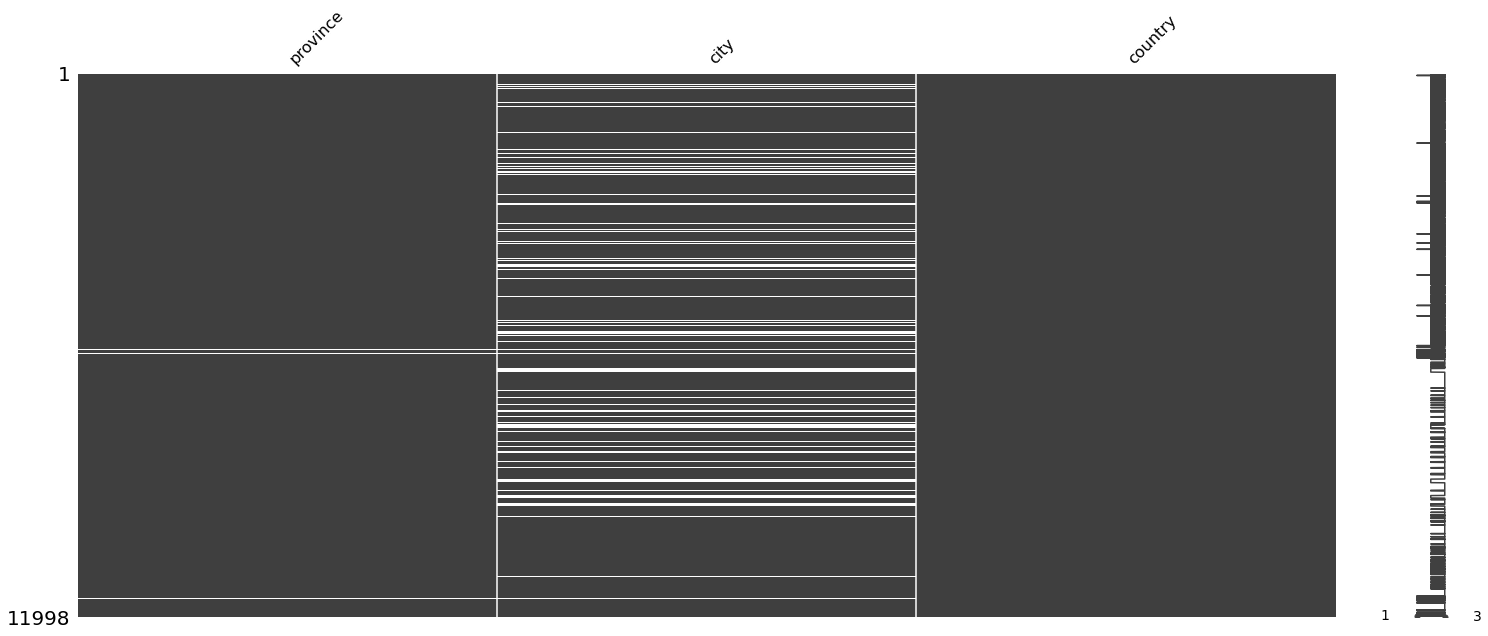

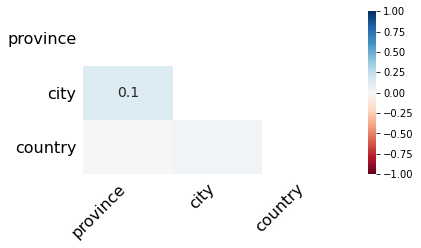

In [33]:
cat_missing_df = df_balanced[["province", "city", "country"]].copy()
msno.matrix(cat_missing_df)
msno.heatmap(cat_missing_df, figsize=(6,3))

In [34]:
#one hot encode province, city and country
dummied_df = pd.get_dummies(df_balanced.copy())
dummied_df.loc[df_balanced.province.isnull(), dummied_df.columns.str.startswith("province_")] = np.nan
dummied_df.loc[df_balanced.country.isnull(), dummied_df.columns.str.startswith("country_")] = np.nan
dummied_df.loc[df_balanced.city.isnull(), dummied_df.columns.str.startswith("city_")] = np.nan
print("info:", dummied_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11998 entries, 0 to 11997
Columns: 864 entries, sex to country_Zimbabwe
dtypes: float64(863), int64(1)
memory usage: 79.2 MB
info: None


In [35]:
#kNN impute missing location values
from sklearn.impute import KNNImputer

imputer = KNNImputer()
imputer.fit(dummied_df)
dummied_n = imputer.transform(dummied_df)

In [36]:
dummied_n_df = pd.DataFrame(dummied_n, columns = dummied_df.columns)
print("sorted list of missing values: ")
print(dummied_n_df.isnull().sum().sort_values(ascending=False).head(3))
print("...")

sorted list of missing values: 
sex                      0
city_Sant Kabir Nagar    0
city_Samastipur          0
dtype: int64
...


In [37]:
columns = list(dummied_n_df.columns)
columns.remove("outcome")
x_all = dummied_n_df[columns]
y_all = dummied_n_df["outcome"]
print(dummied_n_df.shape)
print(x_all.shape, y_all.shape)

(11998, 864)
(11998, 863) (11998,)


In [38]:
#split data into train, test and validation sets
from sklearn.model_selection import train_test_split

x_train_test, x_validation, y_train_test, y_validation = train_test_split(x_all, y_all, test_size=0.15, random_state=0)

train_X, test_X, train_y, test_y = train_test_split(x_train_test, y_train_test, test_size=0.18, random_state=0)

print(train_X.shape, train_y.shape, x_validation.shape, y_validation.shape, test_X.shape, test_y.shape)

(8362, 863) (8362,) (1800, 863) (1800,) (1836, 863) (1836,)


In [39]:
#hyperparameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#logistic regression
test_log_reg = LogisticRegression(max_iter=4000)

#hyperparameters to test for logistic regression
solvers = ["liblinear", "newton-cg", "lbfgs"]
c_nos = [0.01, 0.1, 1.0, 10, 100]
penalty = ["l2"]

#logistic regression testing for best hyperparameters
search = dict(C=c_nos, solver=solvers, penalty=penalty)
R_K_Fold = RepeatedStratifiedKFold(n_splits=10,random_state=0, n_repeats=3)
grid_search = GridSearchCV(estimator=test_log_reg, param_grid=search, n_jobs=-1, cv=R_K_Fold, scoring='accuracy', 
                           error_score=0)
grid_result = grid_search.fit(x_validation, y_validation)
print("log reg done")


#k nearest neighbours
test_kNN_model = KNeighborsClassifier()

#hyperparameters to test for k nearest neighbours
distance_metric = ["manhattan", "euclidian", "minkowski"]
number_nearest_neighbours = range(9, 31, 2)
weight = ["distance", "uniform"]

#testing best hyperparameters for kNN
kNN_search = dict(weights=weight, n_neighbors=number_nearest_neighbours, metric=distance_metric)
kNN_K_Fold = RepeatedStratifiedKFold(n_splits=10,random_state=0, n_repeats=3)
kNN_grid_search = GridSearchCV(estimator=test_kNN_model, param_grid=kNN_search, n_jobs=-1, cv=kNN_K_Fold, scoring='accuracy', 
                           error_score=0)
kNN_grid_result = kNN_grid_search.fit(x_validation, y_validation)
print("kNN done")


#random forest
test_random_forest_model = RandomForestClassifier()

#hyperparameters to test for random forest
features_max = ["log2", "sqrt", "auto"]
estimators = [10, 100, 1000]

#testing best hyperparameters for SVM
RF_search = dict(max_features=features_max, n_estimators=estimators)
RF_K_Fold = RepeatedStratifiedKFold(n_splits=10,random_state=0, n_repeats=3)
RF_grid_search = GridSearchCV(estimator=test_random_forest_model, param_grid=RF_search, n_jobs=-1, cv=RF_K_Fold,
                            scoring='accuracy', error_score=0)
RF_grid_result = RF_grid_search.fit(x_validation, y_validation)
print("RF done")

log reg done
kNN done
RF done


In [40]:
print("best logistic regression hyperparams: ", grid_result.best_params_)
print("accuracy: ", grid_result.best_score_)
print("standard deviation: ", grid_result.cv_results_['std_test_score'][grid_result.best_index_], "\n")
print("best kNN hyperparams: ", kNN_grid_result.best_params_)
print("accuracy: ", kNN_grid_result.best_score_)
print("standard deviation: ", kNN_grid_result.cv_results_['std_test_score'][kNN_grid_result.best_index_], "\n")
print("best RF hyperparams: ", RF_grid_result.best_params_)
print("accuracy: ", RF_grid_result.best_score_)
print("standard deviation: ", RF_grid_result.cv_results_['std_test_score'][RF_grid_result.best_index_])

best logistic regression hyperparams:  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy:  0.6685185185185184
standard deviation:  0.028843744403611163 

best kNN hyperparams:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
accuracy:  0.673888888888889
standard deviation:  0.027597563559185658 

best RF hyperparams:  {'max_features': 'log2', 'n_estimators': 100}
accuracy:  0.6822222222222222
standard deviation:  0.03208784239598589


In [41]:
#implementation of the 3 models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#linear regression model
my_log_reg = LogisticRegression(max_iter=4000, solver="liblinear", C=1.0, penalty="l2")
my_log_reg.fit(train_X, train_y)
#threshold = 0.5
pred_y = my_log_reg.predict(test_X)
print("linear reg done")
pred_train = my_log_reg.predict(train_X)

#k nearest neighbour model
kNN_model = KNeighborsClassifier(metric="manhattan", n_neighbors=11, weights="uniform")
kNN_model.fit(train_X, train_y)
kNN_y_pred = kNN_model.predict(test_X)
print("kNN done")
kNN_pred_train = kNN_model.predict(train_X)

#Random forest model
random_forest_model = RandomForestClassifier(max_features="log2", n_estimators=100)
random_forest_model.fit(train_X, train_y)
RF_y_pred = random_forest_model.predict(test_X)
print("RF done \n\n")
RF_pred_train = random_forest_model.predict(train_X)

from sklearn.metrics import accuracy_score

#print("logistic regression model accuracy score on training set: ", accuracy_score(pred_train, train_y))
print("logistic regression model accuracy score on test set: ", accuracy_score(test_y, pred_y), "\n")
#print("kNN model accuracy score on training set: ", accuracy_score(kNN_pred_train, train_y))
print("K nearest neighbours model accuracy score on test set: ", accuracy_score(test_y, kNN_y_pred), "\n")
#print("RF model accuracy score on training set: ", accuracy_score(RF_pred_train, train_y))
print("random forest model accuracy score on test set: ", accuracy_score(test_y, RF_y_pred))

linear reg done
kNN done
RF done 


logistic regression model accuracy score on test set:  0.6933551198257081 

K nearest neighbours model accuracy score on test set:  0.6742919389978214 

random forest model accuracy score on test set:  0.7096949891067538


In [42]:
#k fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#logistic regression cross validation
k_fold = KFold(shuffle=True, random_state=0, n_splits=10)
log_all_scores = cross_val_score(my_log_reg, x_train_test, y_train_test, cv=k_fold, scoring="accuracy")
print("log reg done")

#kNN cross validation
kNN_k_fold = KFold(shuffle=True, random_state=0, n_splits=10)
kNN_all_scores = cross_val_score(kNN_model, x_train_test, y_train_test, cv=kNN_k_fold, scoring="accuracy")
print("kNN done")

#random forest cross validation
RF_k_fold = KFold(shuffle=True, random_state=0, n_splits=10)
RF_all_scores = cross_val_score(random_forest_model, x_train_test, y_train_test, cv=RF_k_fold, scoring="accuracy")
print("RF done")

log reg done
kNN done
RF done


In [46]:
print("logistic regression accuracies: ", log_all_scores)
print("logistic regression average cross validation accuracy: ", (sum(log_all_scores)/len(log_all_scores)))
print("standard deviation: ", np.std(log_all_scores), "\n")
print("k nearest neighbour accuracies: ", kNN_all_scores)
print("k nearest neighbour average cross validation accuracy: ", (sum(kNN_all_scores)/len(kNN_all_scores)))
print("standard deviation: ", np.std(kNN_all_scores), "\n")
print("random forest accuracies: ", RF_all_scores)
print("random forest average cross validation accuracy: ", (sum(RF_all_scores)/len(RF_all_scores)))
print("standard deviation: ", np.std(RF_all_scores))

logistic regression accuracies:  [0.7        0.68921569 0.70980392 0.7        0.70294118 0.7254902
 0.69803922 0.69117647 0.69185476 0.68400393]
logistic regression average cross validation accuracy:  0.6992525351651947
standard deviation:  0.011265658299311147 

k nearest neighbour accuracies:  [0.69509804 0.69509804 0.69901961 0.70196078 0.69901961 0.69019608
 0.68431373 0.68823529 0.69479882 0.69970559]
k nearest neighbour average cross validation accuracy:  0.6947445592564799
standard deviation:  0.005341836688143627 

random forest accuracies:  [0.7127451  0.70980392 0.72156863 0.70490196 0.71862745 0.73235294
 0.7245098  0.69705882 0.70559372 0.70264966]
random forest average cross validation accuracy:  0.7129812003309666
standard deviation:  0.010507425028306639


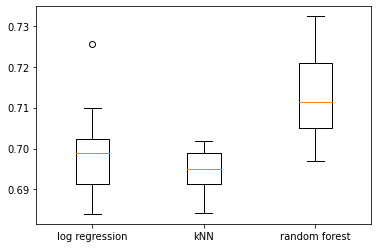

In [45]:
figure = plt.figure()
axis = figure.add_subplot(111)
plt.boxplot([log_all_scores, kNN_all_scores, RF_all_scores])
axis.set_xticklabels(["log regression", "kNN", "random forest"])
plt.show()

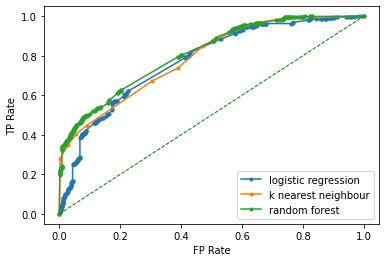

Area under ROC curve for logistic regression:  0.7741687630529714
Area under ROC curve for k nearest neighbours:  0.7885620372128346
Area under ROC curve for random forest:  0.8104886557812796


In [47]:
#plot roc curves
from sklearn.metrics import roc_curve, roc_auc_score

#logarithmic regression posotive probabilities
log_y_probs = my_log_reg.predict_proba(test_X)
log_y_probs = log_y_probs[:, 1]
#find AUC 
log_reg_auc_scores = roc_auc_score(test_y, log_y_probs)
#make and plot ROC curves
log_reg_fp, log_reg_tp, l = roc_curve(test_y, log_y_probs) 
plt.plot(log_reg_fp, log_reg_tp, marker='.', label="logistic regression")

#kNN posotive probabilities
kNN_y_probs = kNN_model.predict_proba(test_X)
kNN_y_probs = kNN_y_probs[:, 1]
#find AUC 
kNN_auc_scores = roc_auc_score(test_y, kNN_y_probs)
#make and plotROC curves
kNN_fp, kNN_tp, l = roc_curve(test_y, kNN_y_probs) 
plt.plot(kNN_fp, kNN_tp, marker='.', label="k nearest neighbour")

#SVM posotive probabilities
RF_y_probs = random_forest_model.predict_proba(test_X)
RF_y_probs = RF_y_probs[:, 1]
#find AUC 
RF_auc_scores = roc_auc_score(test_y, RF_y_probs)
#make and plotROC curves
RF_fp, RF_tp, l = roc_curve(test_y, RF_y_probs) 
plt.plot(RF_fp, RF_tp, marker='.', label="random forest")

# Reference line
plt.plot([0, 1], [0, 1], color="green", lw=1, linestyle='--')

plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.legend()
plt.show()

print("Area under ROC curve for logistic regression: ", log_reg_auc_scores)
print("Area under ROC curve for k nearest neighbours: ", kNN_auc_scores)
print("Area under ROC curve for random forest: ", RF_auc_scores)

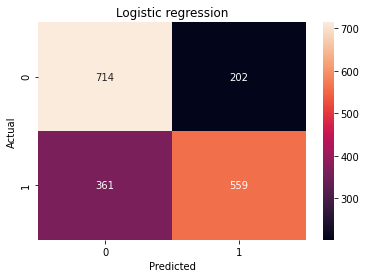

      sensitivity:  0.6076086956521739
      specificity:  0.7794759825327511


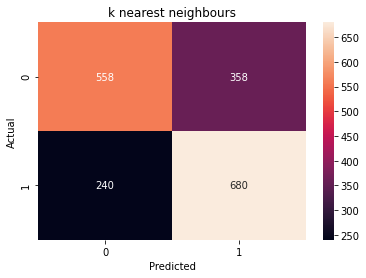

      sensitivity:  0.7391304347826086
      specificity:  0.6091703056768559


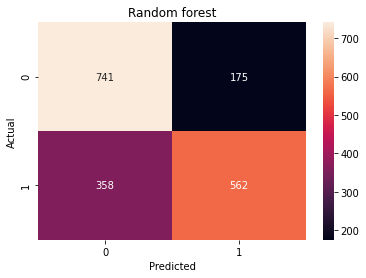

       sensitivity:  0.6108695652173913
       specificity:  0.8089519650655022


In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#logistic regression confusion matrix
log_matrix = confusion_matrix(test_y, pred_y)

#kNN confusion matrix
kNN_matrix = confusion_matrix(test_y, kNN_y_pred)

#SVM confusion matrix
RF_matrix = confusion_matrix(test_y, RF_y_pred)

sns.heatmap(log_matrix, fmt="", annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Logistic regression')
plt.show()
print("      sensitivity: ", log_matrix[1][1]/(log_matrix[1][1] + log_matrix[1][0]))
print("      specificity: ", log_matrix[0][0]/(log_matrix[0][0] + log_matrix[0][1]))

sns.heatmap(kNN_matrix, fmt="", annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('k nearest neighbours')
plt.show()
print("      sensitivity: ", kNN_matrix[1][1]/(kNN_matrix[1][1] + kNN_matrix[1][0]))
print("      specificity: ", kNN_matrix[0][0]/(kNN_matrix[0][0] + kNN_matrix[0][1]))

sns.heatmap(RF_matrix, fmt="", annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Random forest')
plt.show()
print("       sensitivity: ", RF_matrix[1][1]/(RF_matrix[1][1] + RF_matrix[1][0]))
print("       specificity: ", RF_matrix[0][0]/(RF_matrix[0][0] + RF_matrix[0][1]))